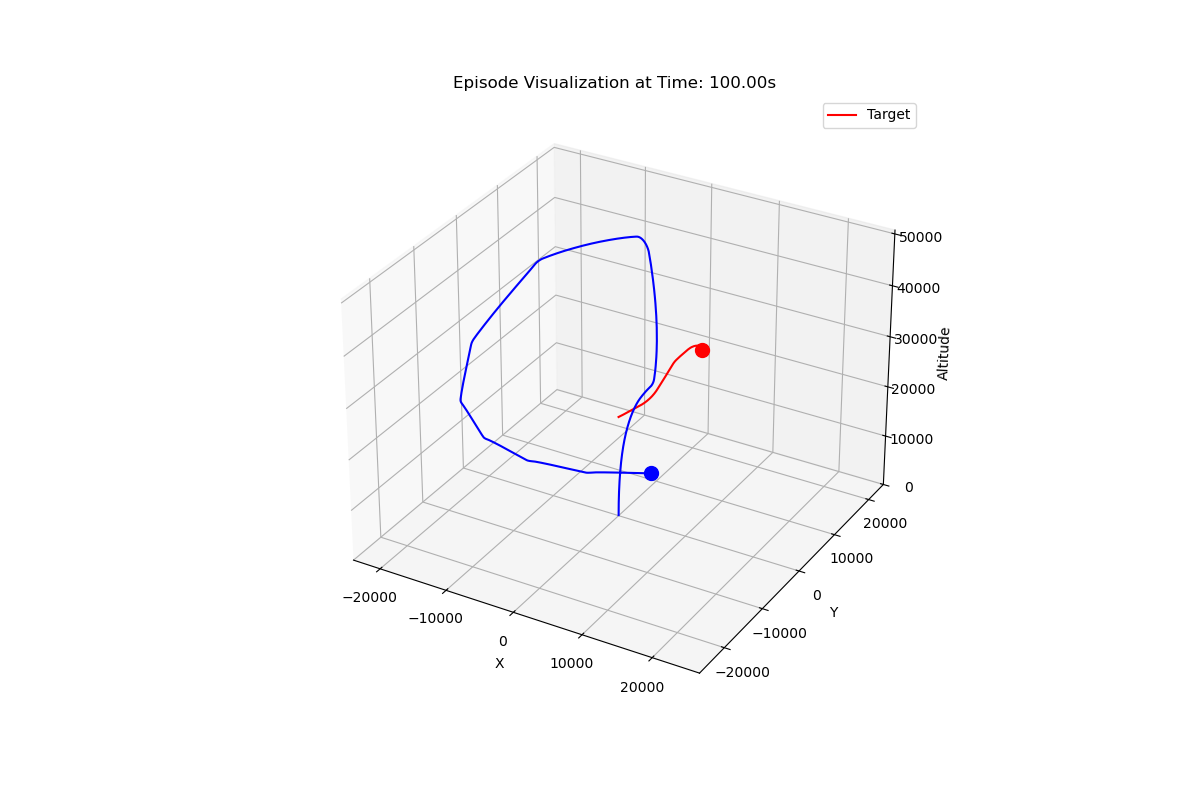

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from gym.environment import MissileEnv, MissileEnvSettings
from gym.observations import InterceptorObservations
from pilots.proportional_nav_pilot import ProportionalNavigationPilot
from models.missile import PhysicalMissleModel
import models.physics as physics
import numpy as np
import time

from visualization.matplot_viz import MatplotVisualizer
from pilots.random_evasion_pilot import RandomEvasionPilot


# physical model configuration
interceptor_speed = physics.mach_to_ms(4.0)  # Speed of the interceptor in m/s
target_speed = physics.mach_to_ms(1.0)  # Speed of the target in m/s
target = PhysicalMissleModel(velocity=np.array([100, target_speed, 0.0]), max_acc=100 * 9.81, pos=np.array([0.0, 0.0, 20_000.0]))
interceptor = PhysicalMissleModel(velocity=np.array([0.0, 0.0, interceptor_speed]), max_acc=100 * 9.81, pos=np.array([0.0, 0.0, 100.0]))

# setup pilots
target_pilot = RandomEvasionPilot()
proportional_nav_pilot = ProportionalNavigationPilot(max_acc=100*9.81, max_speed=interceptor_speed, n=7.0)

# setting up the environment
settings = MissileEnvSettings()
settings.time_step = 0.01    # Time step for the simulation
settings.realtime = False    # Runs faster than real-time
settings.time_limit = 200.0  # Time-limit for the episode
env = MissileEnv(settings=settings, target=target, interceptor=interceptor, target_pilot=target_pilot)

done = False
obs = env.reset()

viz = MatplotVisualizer()
viz.set_episode_data(env.current_episode)

last_time = time.time()
max_render_fps = 10.0

while not done:
    # get un-normalized observations for the interceptor (environment outputs normalized observations for RL agent)
    obs = env.get_interceptor_observations(settings.time_step).pack()

    # pilot the interceptor using the proportional navigation algorithm
    action = proportional_nav_pilot.step(obs, settings.time_step)
    obs, reward, done, _, _ = env.step(action)  # Take a step in the environment
    
# viz.playback(env.sim_time, speed=5.0)
viz.render(env.sim_time)

### Save and Playback

In [22]:
viz.playback(env.sim_time, speed=10.0)
viz.save_playback("output.gif", env.sim_time, 10.0, 5)

MovieWriter imagemagick unavailable; using Pillow instead.


Creating GIF with 51 frames.
GIF saved as output.gif


## Plot Distance over time

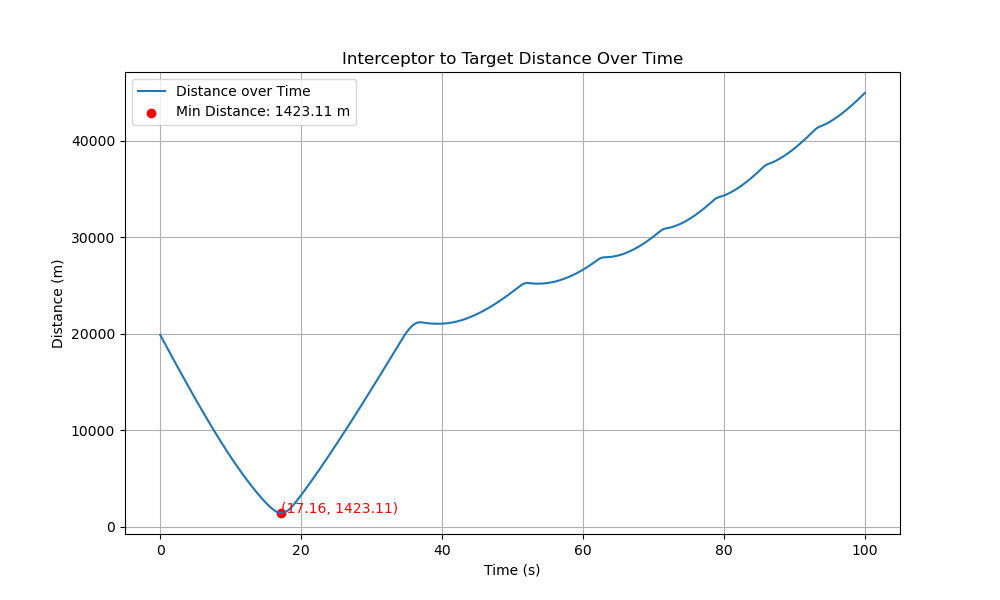

In [21]:
# get all distances from the interceptor to the target
distances = {time: state.distance for time, state in env.current_episode.get_interceptor("Agent").states.all.items()}

import matplotlib.pyplot as plt
import numpy as np

times = list(distances.keys())
distance_values = list(distances.values())

plt.figure(figsize=(10, 6))
plt.plot(times, distance_values, label="Distance over Time")

# Find the minimum value and its corresponding time
min_distance = min(distance_values)
min_time = times[distance_values.index(min_distance)]

# Add a label for the minimum value
plt.scatter(min_time, min_distance, color='red', label=f"Min Distance: {min_distance:.2f} m")
plt.text(min_time, min_distance, f"({min_time:.2f}, {min_distance:.2f})", color='red', fontsize=10)

plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Interceptor to Target Distance Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Missile Interceptor Reinforcement Learning

## Proportional Guidance